# <a name="C1"><font color='Blue'><h1><center>I. Import package nécessaire</center></h1></font></a>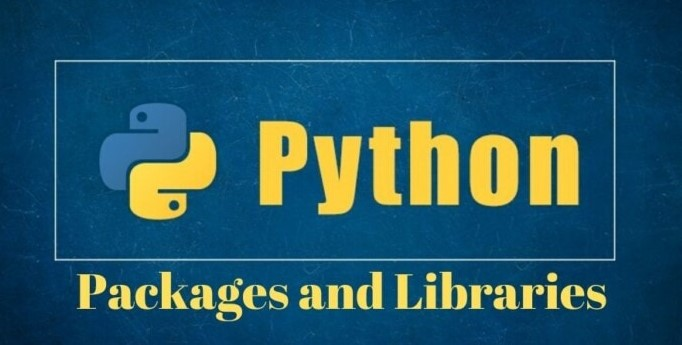

In [47]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from copy import deepcopy
import joblib
from function_utils import *

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
%matplotlib inline
from pylab import rcParams
import warnings
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')
sns.set(style = "darkgrid")

In [4]:
convertMillis(4564826.023)

'52D : 20h : 0min : 26s'

</Br>

</Br>

# <a name="C2"><font color='orange'><h1><center>II. Import Dataset</center></h1></font></a>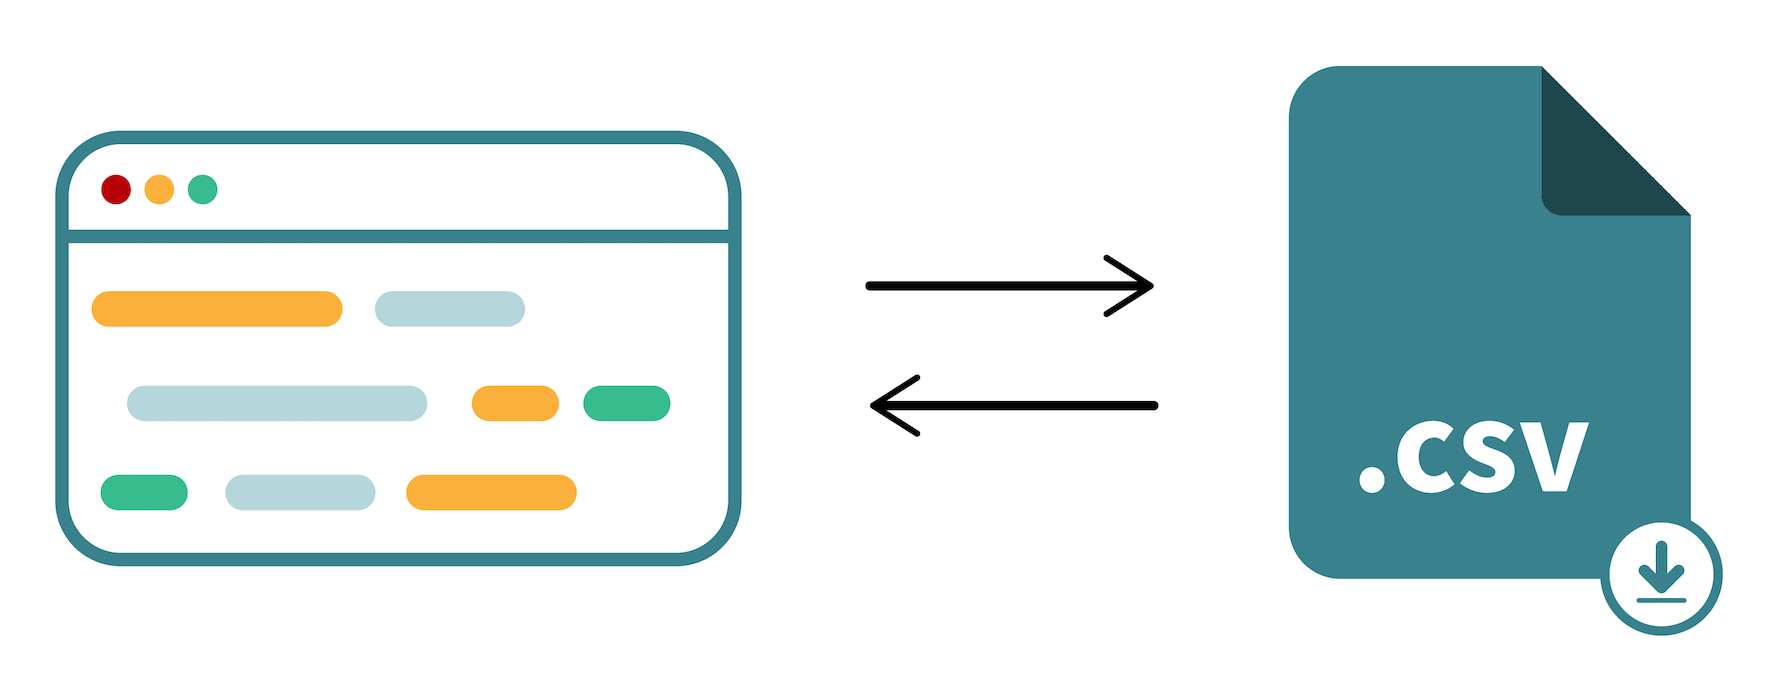

In [5]:
df = pd.read_csv('data/source/application_train.csv')
test_df = pd.read_csv('data/source/application_test.csv')

In [6]:
def clean_data1(data):
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    data = data[data['CODE_GENDER'] != 'XNA']

    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        data[bin_feature], uniques = pd.factorize(data[bin_feature])
    # Categorical features with One-Hot encode
    #df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    data['DAYS_EMPLOYED_PERC'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    data['INCOME_CREDIT_PERC'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
    data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['ANNUITY_INCOME_PERC'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['PAYMENT_RATE'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    return data

In [7]:
df = clean_data1(df)
test_df = clean_data1(test_df)

## <font color='orange'> * Import sauvegarde dataset</font>

In [8]:
if 'df' not in locals():
    print("Le dataset sera importé à partir d'une sauvegarde .csv")
    df = pd.read_csv('data/cleaned/df_cleaned.csv',sep=';')

In [9]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,Cash loans,0,0,0,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,1.0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0,Cash loans,1,0,1,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0,Revolving loans,0,1,0,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0,Cash loans,1,0,0,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0,Cash loans,0,0,0,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.152418,0.236842,121500.0,0.179963,0.042623


In [10]:
df.shape

(307507, 127)

</Br>

</Br>

# <a name="C3"><font color='green'><h1><center>III. Machine Learnig</center></h1></font></a>

## <a name="C31"><font color='green'>III.1 packages nécessaires modélisation</font></a>
</Br>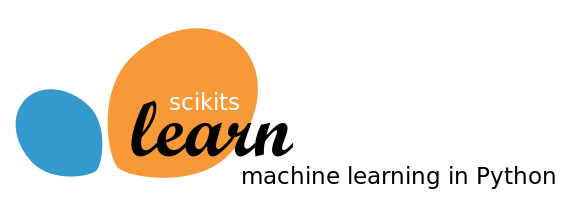

In [61]:
# Modelisation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (HistGradientBoostingClassifier, 
                              GradientBoostingClassifier,
                              RandomForestClassifier, 
                              AdaBoostClassifier)

from lightgbm import LGBMClassifier as lgbmc
from sklearn import dummy

# Cross-Validation
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

# Metrics
from sklearn.metrics import (roc_auc_score, f1_score, recall_score, 
                             accuracy_score, log_loss ,precision_score,
                            roc_curve, ConfusionMatrixDisplay )

# pipeline data transformation
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer , make_column_selector
from sklearn.preprocessing import OneHotEncoder,StandardScaler

</Br>

</Br>

## <a name="C32"><font color='green'>III.2 Train test Validation split</font></a>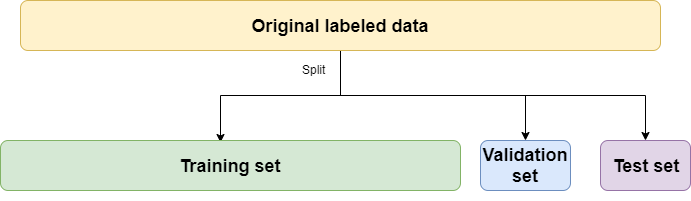

In [12]:
X = df.drop(columns=['TARGET','SK_ID_CURR'])
y = df['TARGET']

## inf
X[X==np.inf] = np.nan

random_seed = 971

# Le dataset est grand on peut diviser le données en train test valiation 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=random_seed,stratify=y) #~~100000 samples
X_test, X_validation, y_test, y_validation = train_test_split( X_test, y_test, test_size=0.5, random_state=random_seed,stratify=y_test) 

print('Le dataset Train se compose de: {0} lignes et {1} colonnes'.format( X_train.shape[0],X_train.shape[1]) )
print('Le dataset Test se compose de: {0} lignes et {1} colonnes'.format( X_test.shape[0],X_test.shape[1]) )
print('Le dataset Validation se compose de: {0} lignes et {1} colonnes'.format(X_validation.shape[0], X_validation.shape[1]) )

Le dataset Train se compose de: 215254 lignes et 125 colonnes
Le dataset Test se compose de: 46126 lignes et 125 colonnes
Le dataset Validation se compose de: 46127 lignes et 125 colonnes


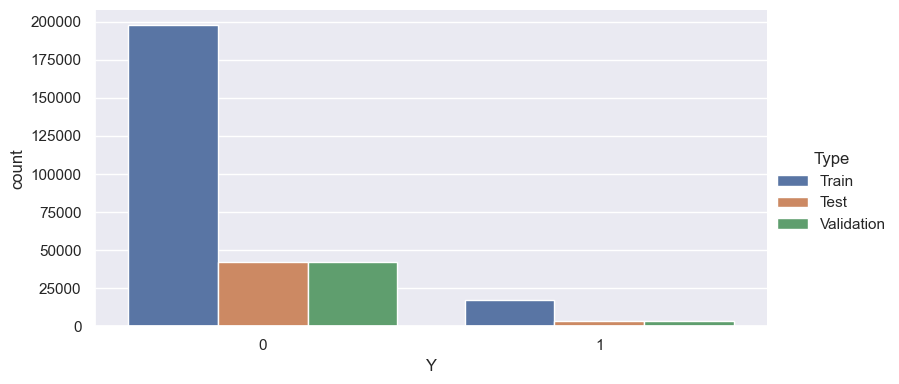

In [13]:
graphData = pd.concat([
    pd.DataFrame(np.c_[y_train,['Train' for x in y_train]],columns=['Y','Type'] ),
    pd.DataFrame(np.c_[y_test,['Test' for x in y_test]],columns=['Y','Type'] ),
    pd.DataFrame(np.c_[y_validation,['Validation' for x in y_validation]],columns=['Y','Type'] )],
    axis=0)

graphData.Y=graphData.Y.astype(np.int16)

sns.catplot(data=graphData, kind='count', x='Y', height=4, aspect=2,hue='Type');

In [14]:
X_train.dtypes

NAME_CONTRACT_TYPE      object
CODE_GENDER              int64
FLAG_OWN_CAR             int64
FLAG_OWN_REALTY          int64
CNT_CHILDREN             int64
                        ...   
DAYS_EMPLOYED_PERC     float64
INCOME_CREDIT_PERC     float64
INCOME_PER_PERSON      float64
ANNUITY_INCOME_PERC    float64
PAYMENT_RATE           float64
Length: 125, dtype: object

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215254 entries, 81522 to 379
Columns: 125 entries, NAME_CONTRACT_TYPE to PAYMENT_RATE
dtypes: float64(71), int64(41), object(13)
memory usage: 206.9+ MB


In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215254 entries, 81522 to 379
Columns: 125 entries, NAME_CONTRACT_TYPE to PAYMENT_RATE
dtypes: float64(71), int64(41), object(13)
memory usage: 206.9+ MB


</Br>

</Br>

</Br>

## <a name="C33"><font color='green'>III.3 Création pipeline preprocessing data</font></a>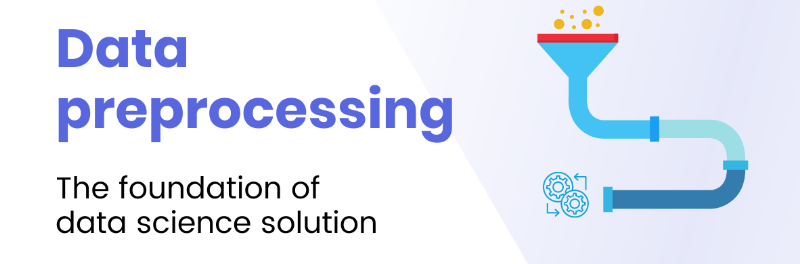

In [17]:

def intermediaire_pipe_pretraitement(X_train,model):
    """
    Fonction qui crée un pipeline, en prétraitant les données en amont puis
    en appliquant un model à la fin

    Args:
        X_train (pandas.core.frame.DataFrame): Training Dataset.
        model (type): model de type sklearn. C'est à dire possedant la méthode fit

    Returns:
        type: Description de la valeur de retour.

    Raises:
        ErrorType: Description de l'erreur éventuellement levée.

    Examples:
        Exemples d'utilisation de la fonction.
    """    
    #Numerical featues
    numeric_features = make_column_selector(dtype_include=np.float64)
    numeric_transformer = Pipeline(
        steps=[('impNumerical', SimpleImputer(strategy="median")) ]
    )

    #Discretes features
    discret_features = make_column_selector(dtype_include=np.int64)
    discret_transformer = Pipeline(
        steps=[('impDiscret', SimpleImputer(strategy = 'most_frequent')) ]
    )

    # categorials features
    categorical_features = make_column_selector(dtype_include="object")
    categorical_transformer = Pipeline(
        steps=[
            ('impCat', SimpleImputer(strategy = 'most_frequent')),
            ('ohe', OneHotEncoder(drop = 'first', handle_unknown = 'ignore',sparse=False)),
        ])

    # columntransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("num",  numeric_transformer, numeric_features),
            ("disc", discret_transformer, discret_features),
            ("cat",  categorical_transformer, categorical_features),
        ])

    # pipeline
    intermediaire_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model",model)]
    )
    
    return intermediaire_pipeline

In [18]:
# Entraîner le pipeline sur les données d'entraînement
intermediaire_pipeline = intermediaire_pipe_pretraitement( X_train,StandardScaler() )
    
# Application pipeline    
X_train_pt = pd.DataFrame(intermediaire_pipeline.fit_transform(X_train),
                          columns=intermediaire_pipeline.get_feature_names_out()
                         )

In [19]:
intermediaire_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impNumerical',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001821A0B6B50>),
                                                 ('disc',
                                                  Pipeline(steps=[('impDiscret',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000018218AE2B50>),
                                                 ('cat',
                                                  Pipeline(steps=[('impCat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001821A1278D0>)])),
                ('model', StandardScaler())])

In [20]:
X_train_pt.head()

,num__AMT_INCOME_TOTAL,num__AMT_CREDIT,num__AMT_ANNUITY,num__AMT_GOODS_PRICE,num__REGION_POPULATION_RELATIVE,num__DAYS_EMPLOYED,num__DAYS_REGISTRATION,num__OWN_CAR_AGE,num__CNT_FAM_MEMBERS,num__EXT_SOURCE_1,...,cat__FONDKAPREMONT_MODE_reg oper spec account,cat__HOUSETYPE_MODE_specific housing,cat__HOUSETYPE_MODE_terraced house,cat__WALLSMATERIAL_MODE_Mixed,cat__WALLSMATERIAL_MODE_Monolithic,cat__WALLSMATERIAL_MODE_Others,cat__WALLSMATERIAL_MODE_Panel,"cat__WALLSMATERIAL_MODE_Stone, brick",cat__WALLSMATERIAL_MODE_Wooden,cat__EMERGENCYSTATE_MODE_Yes
0,1.111520,-0.135154,-0.119380,-0.240315,0.309525,0.453656,1.022546,0.973500,0.928981,0.012651,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
1,-0.100237,-0.649958,-0.288185,-0.544561,0.309525,-2.357397,1.294713,-0.006215,-0.168448,0.104088,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
2,0.505641,-0.017281,-0.306182,-0.240315,1.830912,0.876951,-0.570118,-1.265848,0.928981,-0.693097,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
3,1.515439,-0.764348,0.301389,-0.727109,-0.012079,-1.479469,0.557758,-0.985929,0.928981,0.012651,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
4,0.182506,1.053627,0.639929,0.854973,-0.716342,0.852629,-0.014987,-0.146174,0.928981,0.012651,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585


In [21]:
X_train_pt.filter(regex='^cat', axis=1).head()

,cat__NAME_CONTRACT_TYPE_Revolving loans,cat__NAME_TYPE_SUITE_Family,cat__NAME_TYPE_SUITE_Group of people,cat__NAME_TYPE_SUITE_Other_A,cat__NAME_TYPE_SUITE_Other_B,"cat__NAME_TYPE_SUITE_Spouse, partner",cat__NAME_TYPE_SUITE_Unaccompanied,cat__NAME_INCOME_TYPE_Commercial associate,cat__NAME_INCOME_TYPE_Maternity leave,cat__NAME_INCOME_TYPE_Pensioner,...,cat__FONDKAPREMONT_MODE_reg oper spec account,cat__HOUSETYPE_MODE_specific housing,cat__HOUSETYPE_MODE_terraced house,cat__WALLSMATERIAL_MODE_Mixed,cat__WALLSMATERIAL_MODE_Monolithic,cat__WALLSMATERIAL_MODE_Others,cat__WALLSMATERIAL_MODE_Panel,"cat__WALLSMATERIAL_MODE_Stone, brick",cat__WALLSMATERIAL_MODE_Wooden,cat__EMERGENCYSTATE_MODE_Yes
0,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435,-0.551162,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
1,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435,-0.551162,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
2,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435,1.814349,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
3,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435,-0.551162,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
4,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,5.114485,-2.081448,-0.551162,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585


In [22]:
del X_train_pt
gc.collect()

3697

## <a name="C33"><font color='green'>III.3 Comparaison performance des différents Models</font></a>

In [23]:
score_auc = dict()

In [24]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,Cash loans,0,0,0,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,1.0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0,Cash loans,1,0,1,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0,Revolving loans,0,1,0,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0,Cash loans,1,0,0,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0,Cash loans,0,0,0,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.152418,0.236842,121500.0,0.179963,0.042623


In [25]:
%whos

Variable                           Type         Data/Info
---------------------------------------------------------
AdaBoostClassifier                 ABCMeta      <class 'sklearn.ensemble.<...>ting.AdaBoostClassifier'>
BaseEstimator                      type         <class 'sklearn.base.BaseEstimator'>
ColumnTransformer                  ABCMeta      <class 'sklearn.compose._<...>ormer.ColumnTransformer'>
ConfusionMatrixDisplay             type         <class 'sklearn.metrics._<...>.ConfusionMatrixDisplay'>
GradientBoostingClassifier         ABCMeta      <class 'sklearn.ensemble.<...>dientBoostingClassifier'>
HistGradientBoostingClassifier     ABCMeta      <class 'sklearn.ensemble.<...>dientBoostingClassifier'>
LogisticRegression                 type         <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
OneHotEncoder                      type         <class 'sklearn.preproces<...>_encoders.OneHotEncoder'>
Pipeline                           ABCMeta      <class 'sklearn.pipelin

### <a name="C331"><font color='green'>III.3.1 Dummy Estimateur</font></a>

In [26]:
%%time
# Use the copy module of Python for deep copy operations
dummy_pipe = deepcopy(intermediaire_pipeline)

# pipe.steps works in the same way as lists do, so I can also insert an item into a specific location:
dummy_pipe.steps.append(['dummy',dummy.DummyClassifier(strategy='most_frequent')])
score_auc['dummyEstimator'] = cross_validate(dummy_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['dummyEstimator']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['dummyEstimator']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 50.00%
L'entrainement s'exécute en moyenne en : 21s
CPU times: total: 734 ms
Wall time: 27.7 s


### <a name="C332"><font color='green'>III.3.2 Logistic Regression</font></a>

In [27]:
%%time
# Use the copy module of Python for deep copy operations
regLog_pipe = deepcopy(intermediaire_pipeline)

# pipe.steps works in the same way as lists do, so I can also insert an item into a specific location:
regLog_pipe.steps.append(['reglog',LogisticRegression(max_iter = 20000)])

#regLog_pipe.fit(X_train, y_train)
score_auc['RegLog_Raw'] = cross_validate(regLog_pipe, X_train, y_train, cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_Raw']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RegLog_Raw']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.55%
L'entrainement s'exécute en moyenne en : 14s
CPU times: total: 359 ms
Wall time: 1min 26s


### <a name="C333"><font color='green'>III.3.3 Adaboost</font></a>

In [28]:
%%time
# Use the copy module of Python for deep copy operations
Ada_pipe = deepcopy(intermediaire_pipeline)
Ada_pipe.steps.append(['Adaboost',AdaBoostClassifier()])

#Compute AUC score
score_auc['Adaboost'] = cross_validate(Ada_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Adaboost']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['Adaboost']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.49%
L'entrainement s'exécute en moyenne en : 49s
CPU times: total: 844 ms
Wall time: 2min 56s


### <a name="C334"><font color='green'>III.3.4 Random Forest</font></a>

In [29]:
%%time
# Use the copy module of Python for deep copy operations
RF_pipe = deepcopy(intermediaire_pipeline)
RF_pipe.steps.append(['RandomForest',RandomForestClassifier(n_jobs=-1)])

#Compute AUC score
score_auc['RandomForest'] = cross_validate(RF_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RandomForest']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 70.53%
L'entrainement s'exécute en moyenne en : 47s
CPU times: total: 891 ms
Wall time: 2min 52s


### <a name="C335"><font color='green'>III.3.5  HistGradientBoostingClassifier</font></a>

In [30]:
%%time
# Use the copy module of Python for deep copy operations
HistGB_pipe = deepcopy(intermediaire_pipeline)
HistGB_pipe.steps.append(['HistGB',HistGradientBoostingClassifier()])

#Compute AUC score
score_auc['HistGradientBoosting'] = cross_validate(HistGB_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['HistGradientBoosting']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['HistGradientBoosting']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 75.72%
L'entrainement s'exécute en moyenne en : 57s
CPU times: total: 781 ms
Wall time: 1min 2s


### <a name="C336"><font color='green'>III.3.6 lightGBM</font></a>

In [41]:
%%time

#lgbmc = LGBMClassifier(nthread=4,)

# Use the copy module of Python for deep copy operations
LGBM_pipe = deepcopy(intermediaire_pipeline)
LGBM_pipe.steps.append(['LightGBM',lgbmc()])

#Compute AUC score
score_auc['LightGBM'] = cross_validate(LGBM_pipe,X_train, y_train,cv = 5, n_jobs = 3, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['LightGBM']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['LightGBM']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 75.85%
L'entrainement s'exécute en moyenne en : 12s
CPU times: total: 734 ms
Wall time: 27.4 s


### <a name="C337"><font color='green'>III.3.7 Gradient Boosting</font></a>

In [32]:
%%time
# Use the copy module of Python for deep copy operations
GradientBoosting_pipe = deepcopy(intermediaire_pipeline)
GradientBoosting_pipe.steps.append(['GradientBoosting',GradientBoostingClassifier()])

#Compute AUC score
score_auc['GradientBoosting'] = cross_validate(GradientBoosting_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['GradientBoosting']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(round(score_auc['GradientBoosting']['fit_time'].sum(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 75.43%
L'entrainement s'exécute en moyenne en : 3685.0586
CPU times: total: 1 s
Wall time: 12min 20s


### <a name="C338"><font color='green'>III.3.8 Linear Discriminant Analysis</font></a>

In [33]:
%%time

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Use the copy module of Python for deep copy operations
LDA_pipe = deepcopy(intermediaire_pipeline)
LDA_pipe.steps.append(['DiscriminantAnalysis',LinearDiscriminantAnalysis()])

#Compute AUC score
score_auc['Discriminant Analysis'] = cross_validate(LDA_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Discriminant Analysis']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(round(score_auc['Discriminant Analysis']['fit_time'].sum(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.50%
L'entrainement s'exécute en moyenne en : 375.3027
CPU times: total: 734 ms
Wall time: 1min 23s


### <a name="C339"><font color='green'>III.3.9 Perceptron</font></a>

In [34]:
%%time

from sklearn.linear_model import Perceptron
# Use the copy module of Python for deep copy operations
Perceptron_pipe = deepcopy(intermediaire_pipeline)
Perceptron_pipe.steps.append(['Perceptron',Perceptron(eta0=0.001,penalty='elasticnet',
                                                      max_iter = 100000,
                                                      early_stopping = True,
                                                      validation_fraction = 0.3,
                                                      n_jobs=-1,n_iter_no_change=10,
                                                      class_weight = 'balanced'
                                                     )])

#Compute AUC score
score_auc['Perceptron'] = cross_validate(Perceptron_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Perceptron']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(convertMillis(score_auc['Perceptron']['fit_time'].sum() )))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 62.02%
L'entrainement s'exécute en moyenne en : 30s
CPU times: total: 469 ms
Wall time: 37.7 s


### <a name="C3310"><font color='green'>III.3.10 Passive Aggressive Classifier</font></a>

In [35]:
%%time

from sklearn.linear_model import PassiveAggressiveClassifier
# Use the copy module of Python for deep copy operations
PAC_pipe = deepcopy(intermediaire_pipeline)
PAC_pipe.steps.append(['Passive Aggressive',PassiveAggressiveClassifier(
    max_iter = 100000,
    early_stopping = True,
    validation_fraction = 0.3,
    n_jobs=-1,n_iter_no_change=10, 
    tol=1e-3)])

#Compute AUC score
score_auc['Passive Aggressive'] = cross_validate(PAC_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Passive Aggressive']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(convertMillis(score_auc['Passive Aggressive']['fit_time'].sum() )))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 60.16%
L'entrainement s'exécute en moyenne en : 6s
CPU times: total: 812 ms
Wall time: 16.2 s


### <a name="C3311"><font color='green'>III.3.11 KNeighbors Classifier</font></a>

In [51]:
%%time

from sklearn.neighbors import KNeighborsClassifier
# Use the copy module of Python for deep copy operations
KNeighbors_pipe = deepcopy(intermediaire_pipeline)
KNeighbors_pipe.steps.append(['KNeighbors',KNeighborsClassifier(n_neighbors=5)])

#Compute AUC score
score_auc['KNeighbors'] = cross_validate(KNeighbors_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['KNeighbors']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(convertMillis(score_auc['KNeighbors']['fit_time'].sum())))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 56.53%
L'entrainement s'exécute en moyenne en : 1s
CPU times: total: 703 ms
Wall time: 3min 12s


### <a name="C3312"><font color='green'>III.3.12 Multi-Layer Perceptron Classifier</font></a>

In [37]:
%%time

from sklearn.neural_network import MLPClassifier
# Use the copy module of Python for deep copy operations
MLPC_pipe = deepcopy(intermediaire_pipeline)
MLPC_pipe.steps.append(['MLPClassifier',MLPClassifier(
    hidden_layer_sizes = (128,128,),
    activation = 'tanh',
    learning_rate = 'adaptive',
    max_iter = 10000,early_stopping=True,
    validation_fraction = 0.3,
    alpha=0.2
)])

#Compute AUC score
score_auc['MLPClassifier'] = cross_validate(MLPC_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['MLPClassifier']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(convertMillis(score_auc['MLPClassifier']['fit_time'].sum())))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 73.87%
L'entrainement s'exécute en moyenne en : 1s
CPU times: total: 859 ms
Wall time: 1min 18s


### <a name="C3313"><font color='green'>III.3.13 Fit modeles</font></a>

#### <a name="C33131"><font color='green'>III.3.13.1 Fit modeles Raw</font></a>

In [42]:
%%time
for clf in [dummy_pipe,regLog_pipe,Ada_pipe,RF_pipe,HistGB_pipe,LGBM_pipe,GradientBoosting_pipe,MLPC_pipe]:
    print("Entrainement du model:",clf.steps[-1][1].__class__.__name__, "en cours!")
    #clf.set_params(classifier__n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Scores obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
          .format(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
                  roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
                  roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
                 )
         )
    print("\n")

Entrainement du model: DummyClassifier en cours!
Scores obtenus sur les datasets
 Train: 50.0000% | Validation : 50.0000% | Test : 50.0000%


Entrainement du model: LogisticRegression en cours!
Scores obtenus sur les datasets
 Train: 75.0086% | Validation : 75.1340% | Test : 74.7943%


Entrainement du model: AdaBoostClassifier en cours!
Scores obtenus sur les datasets
 Train: 75.0545% | Validation : 75.1408% | Test : 75.0686%


Entrainement du model: RandomForestClassifier en cours!
Scores obtenus sur les datasets
 Train: 100.0000% | Validation : 71.6651% | Test : 71.7447%


Entrainement du model: HistGradientBoostingClassifier en cours!
Scores obtenus sur les datasets
 Train: 80.2824% | Validation : 76.6558% | Test : 76.5240%


Entrainement du model: LGBMClassifier en cours!
Scores obtenus sur les datasets
 Train: 80.8394% | Validation : 76.6873% | Test : 76.4618%


Entrainement du model: GradientBoostingClassifier en cours!
Scores obtenus sur les datasets
 Train: 76.4251% | Validatio

In [39]:
%%time
for clf in [PAC_pipe,Perceptron_pipe,KNeighbors_pipe, LDA_pipe,]:
    print("Entrainement du model:",clf.steps[-1][1].__class__.__name__, "en cours!")
    #clf.set_params(classifier__n_jobs=-1)
    clf.fit(X_train, y_train)
    if (hasattr(clf, 'predict_proba') and callable(getattr(clf, 'predict_proba'))):
        print("Scores obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
              .format(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
                      roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
                      roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
                     )
             
        print("\n")
        
    else:
        roc_auc_train = clf.decision_function(X_train)
        print('AttributeError: \'',clf.steps[-1][1].__class__.__name__,'\' object has no attribute \'predict_proba\'!!!')
        print("Scores accuracy obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
              .format(roc_auc_score(y_train, (clf.decision_function(X_train) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) ),
                      roc_auc_score(y_validation, (clf.decision_function(X_validation) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) ),
                      roc_auc_score(y_test, (clf.decision_function(X_test) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) ),   
                     )
             )
        print("\n")

Entrainement du model: PassiveAggressiveClassifier en cours!
AttributeError: ' PassiveAggressiveClassifier ' object has no attribute 'predict_proba'!!!
Scores accuracy obtenus sur les datasets
 Train: 61.5029% | Validation : 61.8872% | Test : 61.8500%


Entrainement du model: Perceptron en cours!
AttributeError: ' Perceptron ' object has no attribute 'predict_proba'!!!
Scores accuracy obtenus sur les datasets
 Train: 61.4034% | Validation : 61.3569% | Test : 62.7258%


Entrainement du model: KNeighborsClassifier en cours!
Scores obtenus sur les datasets
 Train: 89.8998% | Validation : 55.5040% | Test : 56.4856%


Entrainement du model: LinearDiscriminantAnalysis en cours!
Scores obtenus sur les datasets
 Train: 74.8842% | Validation : 74.9680% | Test : 74.7188%




#### <a name="C33132"><font color='green'>III.3.13.2 Search Best modeles</font></a>

In [24]:
from sklearn.model_selection import GridSearchCV

In [55]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

### <a name="C34"><font color='green'>III.4 Comparaison des modeles</font></a>

In [43]:
pd.DataFrame(score_auc).applymap(lambda x: np.round(x.mean(),5) )\
.T.sort_values(by = 'test_score', ascending = False)

,fit_time,score_time,test_score
LightGBM,12.74255,0.62876,0.75846
HistGradientBoosting,57.84347,1.86857,0.75720
GradientBoosting,737.01173,1.02573,0.75430
RegLog_Raw,74.93105,0.61824,0.74549
Discriminant Analysis,75.06054,2.34786,0.74503
Adaboost,169.43265,5.07760,0.74492
MLPClassifier,72.30084,0.85406,0.73866
RandomForest,167.60804,2.50283,0.70528
Perceptron,18.07236,0.45320,0.62018
Passive Aggressive,13.30992,0.49268,0.60157


### <font color='green'> _**Lightgbm est le meilleur model**_ </font> 

In [49]:
from sklearn.metrics import roc_curve
def generate_auc_roc_curve(clf, X_test,y_test):
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label = clf.steps[-1][1].__class__.__name__+': AUC ='+str(auc))
    plt.legend(loc=4)
    pass

NotFittedError: This LinearDiscriminantAnalysis instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

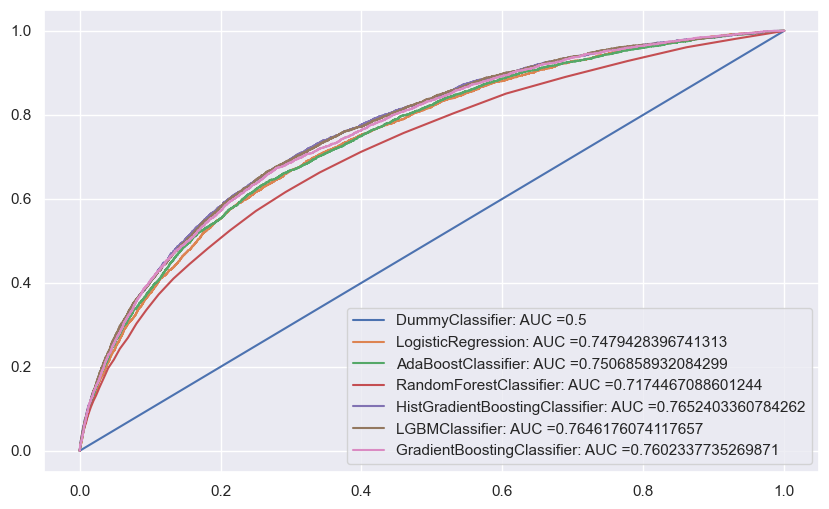

In [52]:
generate_auc_roc_curve(dummy_pipe,X_test,y_test)
generate_auc_roc_curve(regLog_pipe,X_test,y_test)
generate_auc_roc_curve(Ada_pipe,X_test,y_test)
generate_auc_roc_curve(RF_pipe,X_test,y_test)
generate_auc_roc_curve(HistGB_pipe,X_test,y_test)
generate_auc_roc_curve(LGBM_pipe,X_test,y_test)
generate_auc_roc_curve(GradientBoosting_pipe,X_test,y_test)

generate_auc_roc_curve(KNeighbors_pipe,X_test,y_test)
generate_auc_roc_curve(LDA_pipe,X_test,y_test)

#AttributeError: 'Perceptron' object has no attribute 'predict_proba'
#generate_auc_roc_curve(Perceptron_pipe,X_test,y_test)

## <a name="C4"><font color='purple'>IV. Sauvegarde des models</font></a>

In [45]:
import joblib
joblib.dump(dummy_pipe, "data/modeles sauvegardés/DummyClassifer_model.sav")
joblib.dump(regLog_pipe,"data/modeles sauvegardés/LogisticRegression_model.sav")
joblib.dump(Ada_pipe,"data/modeles sauvegardés/AdaBoostClassifier_model.sav")
joblib.dump(RF_pipe,"data/modeles sauvegardés/RandomForestClassifier_model.sav")
joblib.dump(HistGB_pipe, "data/modeles sauvegardés/HistGradientBoostingClassifier_model.sav")
joblib.dump(LGBM_pipe,"data/modeles sauvegardés/lightGBMClasiifer_model.sav")
joblib.dump(GradientBoosting_pipe,"data/modeles sauvegardés/GradientBoostingClassifier_model.sav")
joblib.dump(MLPC_pipe, "data/modeles sauvegardés/MultiLayerPerceptronClassifier_model.sav")

joblib.dump(KNeighbors_pipe,  "data/modeles sauvegardés/KNeighborsClassifier_model.sav")
joblib.dump(LDA_pipe, "data/modeles sauvegardés/DiscriminanteAnalysisLineaire_model.sav")
joblib.dump(PAC_pipe, "data/modeles sauvegardés/PassiveAggressiveClassifier_model.sav")
joblib.dump(Perceptron_pipe, "data/modeles sauvegardés/simplePerceptronClassifier_model.sav")

# Model de traitement des données
joblib.dump(intermediaire_pipeline, "data/modeles sauvegardés/intermediaire_pipeline.sav")

['data/modeles sauvegardés/intermediaire_pipeline.sav']

In [25]:
gc.collect()

0

## <a name="C5"><font color='blue'>V. MLflow</font></a>

In [53]:
import mlflow

In [101]:
def eval_metrics(actual, pred, pred_proba):
    accuracy = accuracy_score(actual, pred)
    precision = precision_score(actual, pred )
    f1 = f1_score(actual, pred)
    recall = recall_score(actual, pred)
    auc = roc_auc_score(actual, pred_proba[:,1])
    return accuracy, precision, f1, recall, auc

### Présentation de MLflow

> MLflow is a platform to streamline machine learning development, including tracking experiments, packaging code into reproducible runs, and sharing and **deploying models**. MLflow offers a set of lightweight APIs that can be used with any existing machine learning application or library (TensorFlow, PyTorch, XGBoost, etc), wherever you currently run ML code (e.g. in notebooks, standalone applications or the cloud). MLflow's current components are:
>- MLflow Tracking: An API to log parameters, code, and results in machine learning experiments and compare them using an interactive UI.
>- MLflow Projects: A code packaging format for reproducible runs using Conda and Docker, so you can share your ML code with others.
>- **MLflow Models: A model packaging format and tools that let you easily deploy the same model (from any ML library) to batch and real-time scoring on platforms >such as Docker, Apache Spark, Azure ML and AWS SageMaker.**
>- MLflow Model Registry: A centralized model store, set of APIs, and UI, to collaboratively manage the full lifecycle of MLflow Models.

[Source](https://github.com/mlflow/mlflow)

--------

MLflow est une librairie dédiée à la gestion du cycle de vie d'un projet de machine learning, à savoir :
- le suivi des résultats liés aux expériences (MLflow Tracking)
- garantir la reproducibilité des expériences et le partage de code (MLflow Projects)
- la gestion des modèles sous un format normalisé afin de simplifier les déploiements locaux ou cloud (MLflow Models)
- la centralisation et le versionnage les modèles (MLflow Model Registry)

**On s'intéresse dans le cadre de l'exercice à MLflow Models uniquement**, vous pouvez explorer les autres fonctionnalités bien entendu, cependant ce n'est pas l'objectif de cet exercice.

-------

### Format de stockage d'un modèle

Un modèle MLflow est un répertoire contenant une liste de fichiers, dont un nommé MLmodel qui liste les différentes flavors (terme MLflow) dans lesquelles le modèle est utilisable.

Les flavors sont une façon pratique de définir comment exécuter un modèle, cette convention facilite le déploiement car la flavor standardise la façon de prédire à partir d'un modèle. MLflow définit par exemple des flavors pour une fonction python, sklearn, tensorflow, xgboost.

Dans le répertoire de sauvegarde du modèle MLflow, le fichier MLmodel contient l'ensemble des flavors disponibles, par exemple :
```yaml
time_created: 2018-05-25T17:28:53.35

flavors:
  sklearn:
    sklearn_version: 0.19.1
    pickled_model: model.pkl
  python_function:
    loader_module: mlflow.sklearn
```

Tous les outils supportant les flavors `python_function` ou `sklearn` pourront utiliser ce modèle, par exemple pour un déploiement avec la commande suivante.

```python
mlflow models serve -m my_model
```

D'autres outils cloud comme AWS SageMaker ou Azure ML peuvent utiliser ces flavors.

[Documentation pour approfondir](https://mlflow.org/docs/latest/models.html#storage-format)

-----------

### <a name="C50"><font color='blue'>V.0 Setting mlflow </font></a>

### infer_signature
Les signatures de modèle définissent les schémas d'entrée et de sortie pour les modèles MLflow, fournissant une interface standard pour codifier et appliquer l'utilisation correcte de vos modèles. 

Les signatures sont récupérées par l'interface utilisateur de suivi MLflow et l'interface utilisateur du registre de modèles pour afficher les entrées et les sorties du modèle. 

Ils sont également utilisés par les outils de déploiement de modèle MLflow pour valider les entrées d'inférence en fonction de la signature attribuée au modèle.

In [55]:
from mlflow.models import infer_signature
signature = infer_signature(X_train,y_train)

In [56]:
# Définir où les Runs sont enregistrées local ou remote
mlflow.set_tracking_uri("data/mlflow/mlruns") 

# Définir l'expérience donnée comme l'expérience active.
# Définir un nom d'expérience, qui doit être unique et sensible à la casse.
# 'OC_projet_7' : path to experiment in remote workspace
mlflow.set_experiment('OC_projet_7') 

# Active (ou désactive) et configure l'autologisation pour les estimateurs scikit-learn.
mlflow.sklearn.autolog(exclusive=False)# Permet de faire appel à l'API de sklearn qui integre tous les algorithme de scikit-learn

2023/06/27 23:21:08 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000018218B34F90>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/06/27 23:21:08 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

AUC: 0.5
CPU times: total: 14.2 s
Wall time: 20.9 s


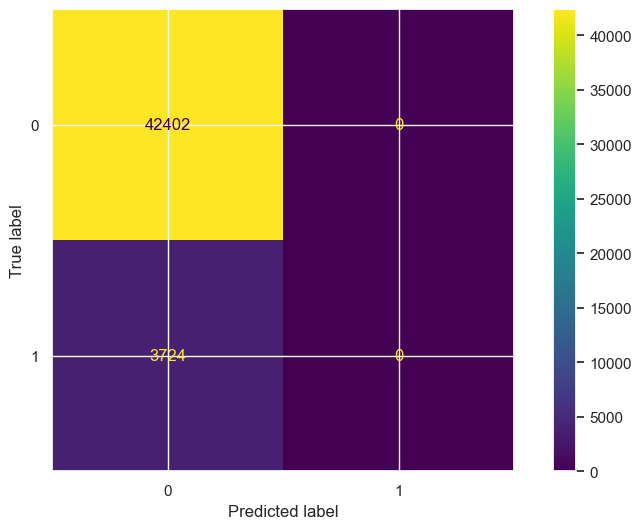

In [106]:
%%time

# Dummy estimator
with mlflow.start_run(run_name='Dummy_Estimator'): #experiment_id= experiment_id
    dummy_pipe.fit(X_train, y_train)
    
    y_pred_proba = dummy_pipe.predict_proba(X_test)
    y_pred = dummy_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    # Log params
    # mlflow.log_param('max_iter' , '100')
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(regLog_pipe, 'pipeline Dummy Estimator', signature=signature)
    #generate_auc_roc_curve(logReg,X_test, y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

2023/06/27 23:21:29 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001821A13F7D0>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/06/27 23:21:29 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

AUC: 0.7479428396741313
CPU times: total: 1min 25s
Wall time: 39.3 s


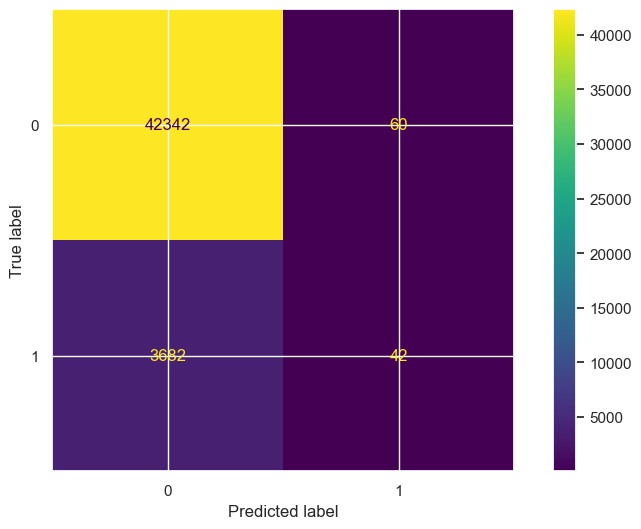

In [107]:
%%time
# premier run
with mlflow.start_run(run_name='Reg_logistic_0'): #experiment_id= experiment_id
    regLog_pipe.fit(X_train, y_train)
    
    y_pred_proba = regLog_pipe.predict_proba(X_test)
    y_pred = regLog_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    # Log params
    # mlflow.log_param('max_iter' , '100')
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(regLog_pipe, 'pipeline Regression Logistic', signature=signature)
    #generate_auc_roc_curve(logReg,X_test, y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

2023/06/27 23:22:09 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001821A13CF90>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/06/27 23:22:09 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

AUC: 0.7652637868803283


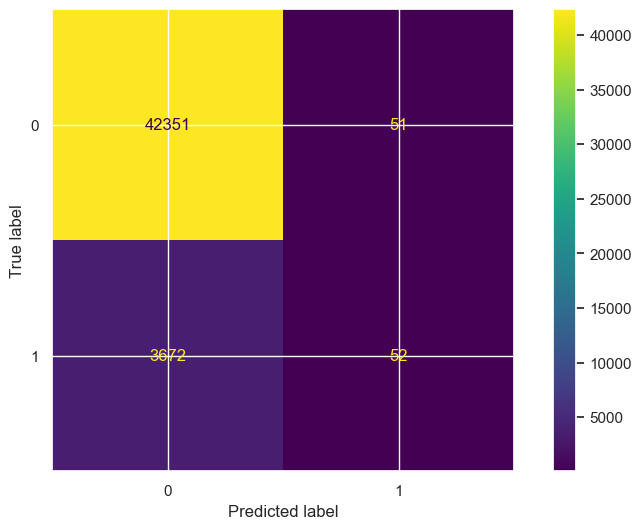

In [108]:
# premier run
with mlflow.start_run(run_name='HistGradientBoosting_0'): #experiment_id= experiment_id
    HistGB_pipe.fit(X_train, y_train)
    
    y_pred_proba = HistGB_pipe.predict_proba(X_test)
    y_pred = HistGB_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    # Log params
    # mlflow.log_param('max_iter' , '100')
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(HistGB_pipe, 'pipeline HistGradient Boosting', signature=signature)
    #generate_auc_roc_curve(logReg,X_test, y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

2023/06/27 23:22:55 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000018201EBC2D0>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/06/27 23:22:55 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

AUC: 0.7646176074117657


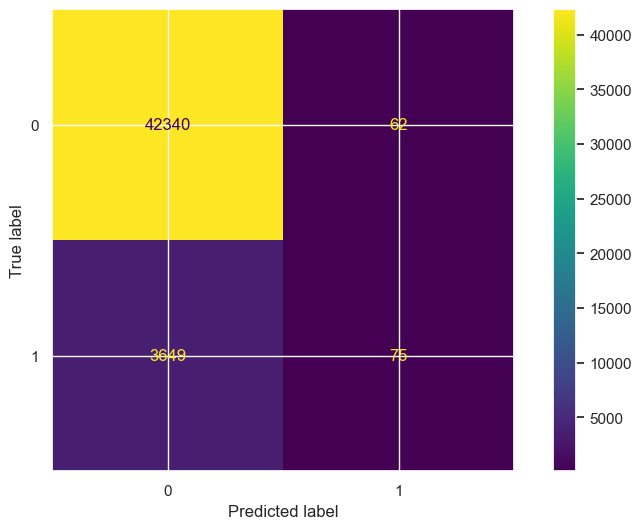

In [109]:
# premier run
with mlflow.start_run(run_name='LightGBM_0'): #experiment_id= experiment_id
    LGBM_pipe.fit(X_train, y_train)
    
    y_pred_proba = LGBM_pipe.predict_proba(X_test)
    y_pred = LGBM_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    # Log params
    # mlflow.log_param('max_iter' , '100')
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(LGBM_pipe, 'pipeline Light Gradient Boosting', signature=signature)
    #generate_auc_roc_curve(logReg,X_test, y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

In [90]:
import streamlit
streamlit

<module 'streamlit' from 'C:\\Users\\eleor\\anaconda3\\envs\\py3_9_projet7_OC_DS\\lib\\site-packages\\streamlit\\__init__.py'>